<a href="https://colab.research.google.com/github/Uwimbabazi-Keza/RSL-Project/blob/main/RSL_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
pip install tensorflow opencv-python mediapipe scikit-learn matplotlib tensorflowjs

In [45]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import numpy as np

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Human Pose Estimation - Mediapipe

In [25]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])



# Preprocess Data

In [26]:
DATA_PATH = '/content/drive/MyDrive/RSL_Dataset'
actions = np.array(['Amata', 'Murakoze', 'Amakuru yawe', 'Guhagarika', 'Umuntu', 'Gushaka', 'Kugira', 'Rwanda', 'Ishuri', 'Muraho'])

no_sequences = 30

sequence_length = 30

def pad_sequence(sequence, target_length):
    if len(sequence) < target_length:

        padding = np.zeros((target_length - len(sequence), 1662))
        sequence = np.vstack((sequence, padding))
    return sequence


sequences, labels = [], []
label_map = {label: num for num, label in enumerate(actions)}

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        action_path = os.path.join(DATA_PATH, action)
        videos = os.listdir(action_path)

        for video in videos:
            video_path = os.path.join(action_path, video)

            cap = cv2.VideoCapture(video_path)
            window = []

            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                if not ret:
                    break


                image, results = mediapipe_detection(frame, holistic)


                draw_styled_landmarks(image, results)


                keypoints = extract_keypoints(results)
                window.append(keypoints)

            window = pad_sequence(np.array(window), sequence_length)
            sequences.append(window)
            labels.append(label_map[action])

            cap.release()

X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)


##Visualizing a Sample from the Dataset

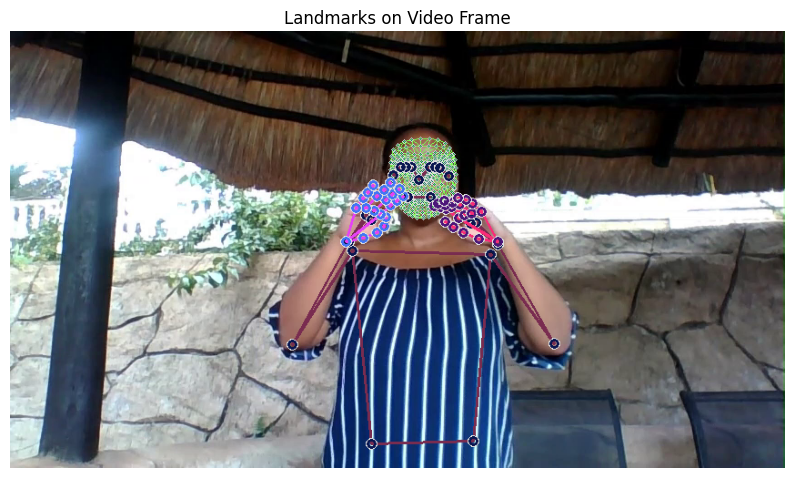

Extracted Keypoints Shape: (1662,)


In [51]:
def visualize_sample(video_path):
    cap = cv2.VideoCapture(video_path)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        ret, frame = cap.read()

        if ret:
            image, results = mediapipe_detection(frame, holistic)

            draw_styled_landmarks(image, results)

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(10, 10))
            plt.imshow(image_rgb)
            plt.axis('off')
            plt.title('Landmarks on Video Frame')
            plt.show()

            keypoints = extract_keypoints(results)
            print(f"Extracted Keypoints Shape: {keypoints.shape}")
        else:
            print("Error: Could not read the video frame.")

    cap.release()

sample_video_path = os.path.join(DATA_PATH, 'Amakuru yawe', 'Amakuru_yawe-02.mp4')
visualize_sample(sample_video_path)




# Train LSTM Model

In [30]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=2000,
          callbacks=[tb_callback, early_stopping])



Epoch 1/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - categorical_accuracy: 0.1111 - loss: 2.7207 - val_categorical_accuracy: 0.0625 - val_loss: 2.5178
Epoch 2/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - categorical_accuracy: 0.1253 - loss: 2.3801 - val_categorical_accuracy: 0.0625 - val_loss: 2.3430
Epoch 3/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - categorical_accuracy: 0.1684 - loss: 2.2381 - val_categorical_accuracy: 0.1250 - val_loss: 2.3053
Epoch 4/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - categorical_accuracy: 0.2064 - loss: 2.2650 - val_categorical_accuracy: 0.1250 - val_loss: 2.2515
Epoch 5/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - categorical_accuracy: 0.1963 - loss: 2.1986 - val_categorical_accuracy: 0.1250 - val_loss: 2.2466
Epoch 6/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - categorical_accuracy: 0.1987 - loss: 2.2137 - val_categorical_accuracy: 0.0625 - val_loss: 2.2956
Epoch 7/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - categorical_accuracy: 0.2041 - los

In [33]:
# Save model
model.save('/content/drive/MyDrive/RSL_Model/rsl_model.h5')
print("Model saved successfully to Google Drive.")


Model saved successfully to Google Drive.


# Evaluation

Test Predictions

In [36]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


In [39]:
#Accuracy, Pricision, Recall, F1
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.875
Precision: 0.890625
Recall: 0.875
F1-Score: 0.8732142857142857


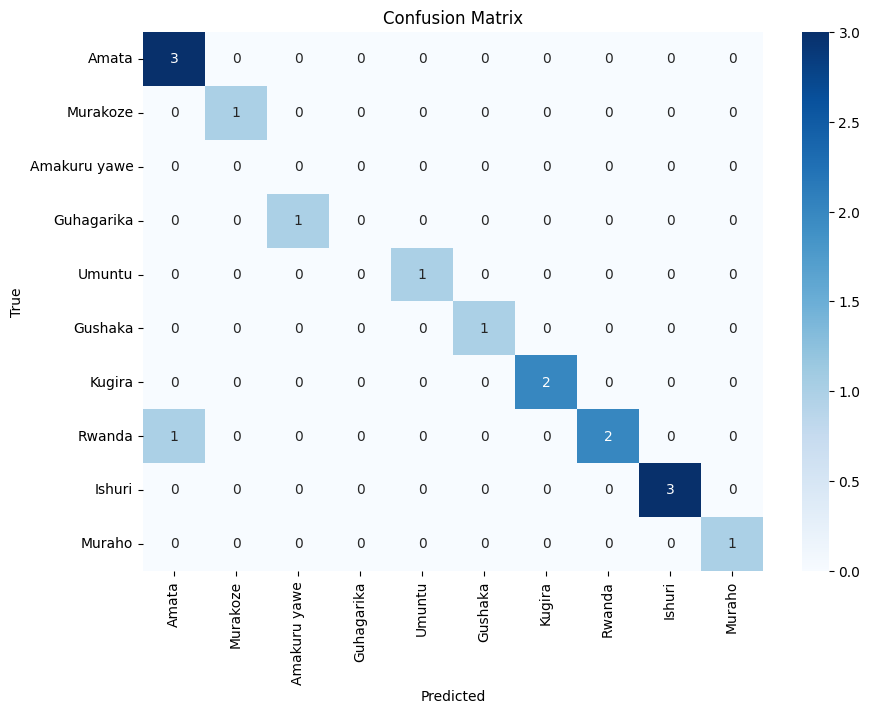

In [40]:
#Confusion Matrix
confuse_me = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(confuse_me, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Summary

In [41]:
report = classification_report(y_true, y_pred_classes, target_names=actions)
print(report)

              precision    recall  f1-score   support

       Amata       0.75      1.00      0.86         3
    Murakoze       1.00      1.00      1.00         1
Amakuru yawe       0.00      0.00      0.00         0
  Guhagarika       0.00      0.00      0.00         1
      Umuntu       1.00      1.00      1.00         1
     Gushaka       1.00      1.00      1.00         1
      Kugira       1.00      1.00      1.00         2
      Rwanda       1.00      0.67      0.80         3
      Ishuri       1.00      1.00      1.00         3
      Muraho       1.00      1.00      1.00         1

    accuracy                           0.88        16
   macro avg       0.78      0.77      0.77        16
weighted avg       0.89      0.88      0.87        16

